# FIT5196 Assessment 2

Student Name: Juan Pablo Grimaldi
Student ID: 32980523

Date: 31 August 2022


Environment: Python 3.9

Libraries used:
* os (for interacting with the operating system, included in Python 3.xxx package) 
* re (for regular expression, installed and imported) 
* pandas (for data manipulation)

-------------------------------------

# Table of Contents


[1. Introduction](#Intro) <br>
[2. Importing Libraries](#libs) <br>
[3. Examining Review Files](#examine) <br>
[4. Loading and Parsing Files](#load) <br>
$\;\;\;\;$[4.1. Defining Regular Expressions](#Reg_Exp) <br>
$\;\;\;\;$[4.2. Extract Information](#Read) <br>
$\;\;\;\;$[4.3. Structure results and data export](#structure) <br>
$\;\;\;\;$[4.4. Debugging](#debugging) <br>
[5. Writing Output to CSV File](#write) <br>
$\;\;\;\;$[5.1. Verification - using the sample files](#test) <br>
[6. Summary](#summary) <br>
[7. References](#Ref) <br>

-------------------------------------

In [327]:
#reset
%reset

## Introduction  <a class="anchor" name="Intro"></a>

In the real world, it's unlikely to have the good fortune of working with perfectly clean data.
Most often than not, data scientists will run into data sets that require some attention before
the analysis can even begin. For example, it's common in domains like Finance to observe outliers
 within stock returns that would create a biased set of estimates when creating the models.

George Box famously said:

> “All models are wrong, but some are useful.”

This reveals that data cleaning is indeed a key part of the process of data analysis, and
this assessment will cover common issues and solutions of working with data.

### Assessment Specifications

For this project, we will use and examine three data sets where each one of them contains a
problem to be resolved:

* `32980523_dirty_data.csv`: detect and fix errors.
* `32980523_outlier_data.csv`: detect and remove outlier rows (to be found w.r.t delivery_fee
attribute).
* `32980523_missing_data.csv`: impute the missing values.

In addition, there are three auxiliary files to be used during parts of the data cleaning process: `branches.csv`,`edges.csv`,`nodes.csv`.
<br>
The dataset contains Food Delivery data from a restaurant in Melbourne, Australia. The restaurant has three branches around CBD area. All three branches share the same menu but they have different management so they operate differently.
<br>
Below are the variables contained in the data sets:
<br>
* `order_id`: A unique id for each order
* `date`: The date the order was made, given in YYYY-MM-DD format
* `time`: The time the order was made, given in hh:mm:ss format
* `order_type`: A categorical attribute representing the different types of orders namely: Breakfast, Lunch or Dinner
* `branch_code`: A categorical attribute representing the branch code in which the order was made. Branch information is given in the branches.csv file.
* `order_items`: A list of tuples representing the order items: first element of the tuple is the
item ordered, and the second element is the quantity ordered for that item.
* `order_price`: A float value representing the order total price.
* `customer_lat`: Latitude of the customer coming from the nodes.csv file.
* `customer_lon`: Longitude of the customer coming from the nodes.csv file.
* `customerHasloyalty?`: A logical variable denoting whether the customer has a loyalty card with
the restaurant (1 if the customer has loyalty and 0 otherwise).
* `distance_to_customer_KM`: A float representing the shortest distance, in kilometers, between the branch and the customer nodes with respect to the nodes.csv and the edges.csv files.
* `delivery_fee`: A float representing the delivery fee of the order.


### Additional Information

The following helpful details are also provided in the brief:

* There are three types of meals:
    * Breakfast - served during morning (8am - 12pm),
    * Lunch - served during afternoon (12:00:01pm - 4pm)
    * Dinner - served during evening (4:00:01pm - 8pm)

* Each meal has a distinct set of items in the menu (ex: breakfast items can't be served during lunch or dinner and so on).

* A useful python package to solve a linear system of equations is numpy.linalg

* Delivery fee is calculated using a different method for each branch. The fee depends linearly (but in different ways for each branch) on:
    1. weekend or weekday (1 or 0) - as a binary variable
    2. time of the day (morning 0, afternoon 1, evening 2) - as a categorical variable
    3. distance between branch and customer

* **If a customer has loyalty, they get a 50% discount on delivery fee**

* The restaurant uses Djikstra algorithm to calculate the shortest distance between customer and restaurant. (explore networkx python package for this or alternatively find a way to implement the algorithm yourself)

* We know that the below columns are error-free:
    * order_id
    * time
    * the numeric quantity in order_items

-------------------------------------

## Enviroment Preparation  <a class="anchor" name="libs"></a>

The packages to be used in this assessment are imported in the following. They are used to fulfill the following tasks:

* **pandas:** to structure the results into a tabular format, as per the assessment requirements.
* **matplotlib:** for visual exploratory data analysis.
* **missingno:** to process and visualise missing data.

In [328]:
import datetime
# import libraries to be used in the assignment
#Basic scientific python libs
import pandas as pd
# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import seaborn as sns
import networkx as nx
# Configure visualisations
%matplotlib inline
# to make things pretty
plt.style.use( 'ggplot' )

-------------------------------------

## Load and Examine Datasets <a class="anchor" name="examine"></a>

<br>Most of the exploratory data analysis will be performed with methods from the `pandas` library.
To begin the process, all the csv files will be read into a dataframe:


In [329]:
#load datasets
dirty_data = pd.read_csv("data/32980523_dirty_data.csv")
missing_data = pd.read_csv("data/32980523_missing_data.csv")
outlier_data = pd.read_csv("data/32980523_outlier_data.csv")

The following sections will cover the process of review and amendment of each of the datasets.

### Dirty Data

Firstly, we will use the info() method to review the variably types within the dataset and print
the data set size.

In [330]:
# review dirty data variable types
print("---- Dirty Data: data types ----")
dirty_data.info()
print("---- Dirty Data: data frame size ----")
dirty_data.shape

---- Dirty Data: data types ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 500 non-null    object 
 1   date                     500 non-null    object 
 2   time                     500 non-null    object 
 3   order_type               500 non-null    object 
 4   branch_code              500 non-null    object 
 5   order_items              500 non-null    object 
 6   order_price              500 non-null    float64
 7   customer_lat             500 non-null    float64
 8   customer_lon             500 non-null    float64
 9   customerHasloyalty?      500 non-null    int64  
 10  distance_to_customer_KM  500 non-null    float64
 11  delivery_fee             500 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 47.0+ KB
---- Dirty Data: data frame size ----


(500, 12)

Next, the head and tail methods from pandas will allow a quick overview of the dataframe structure.

In [331]:
#inspect dirty data head
print("---- dataframe head ----")
display(dirty_data.head())
print("---- dataframe tail ----")
#inspect dirty data head
display(dirty_data.tail())

---- dataframe head ----


,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDJ06243,2021-11-02,18:08:27,Dinner,TP,"[('Salmon', 4), ('Pasta', 2), ('Fish&Chips', 1...",308.0,-37.806521,144.944874,0,10.082,13.802598
1,ORDA10907,2021-11-03,18:08:27,Dinner,BK,"[('Salmon', 5), ('Pasta', 5)]",342.5,-37.810712,144.946133,0,9.145,16.150990
2,ORDA06776,2021-08-14,15:26:11,Lunch,BK,"[('Fries', 1), ('Salad', 7), ('Chicken', 2), (...",320.4,-37.819004,144.954318,0,8.676,16.680944
3,ORDY05744,2021-10-26,17:48:10,Dinner,TP,"[('Salmon', 7), ('Pasta', 10), ('Shrimp', 5)]",832.0,-37.817244,144.967764,0,11.792,11.549074
4,ORDX00833,2021-05-05,12:03:22,Lunch,BK,"[('Salad', 2), ('Steak', 10), ('Chicken', 2), ...",892.4,-37.809557,144.972643,0,6.714,12.512411


---- dataframe tail ----


,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
495,ORDX04741,2021-03-24,10:42:15,Breakfast,BK,"[('Coffee', 9), ('Pancake', 9)]",249.75,-37.806837,144.951380,0,8.581,13.103430
496,ORDJ05472,2021-10-03,17:07:36,Dinner,TP,"[('Pasta', 4), ('Fish&Chips', 7), ('Shrimp', 2)]",463.00,-37.807966,144.945429,0,9.956,15.517818
497,ORDK01012,2021-06-16,13:24:30,Lunch,BK,"[('Burger', 5), ('Chicken', 5), ('Fries', 10),...",600.40,-37.807797,144.973202,0,6.525,11.838280
498,ORDK04997,2021-03-16,10:21:58,Breakfast,BK,"[('Eggs', 8), ('Coffee', 2), ('Cereal', 3), ('...",283.50,-37.799207,144.961314,0,8.333,13.031216
499,ORDA02222,2021-04-27,11:53:14,Breakfast,BK,"[('Pancake', 7), ('Coffee', 1), ('Cereal', 8)]",321.25,-37.803561,144.918101,0,11.587,16.161815


Lastly, the `describe` method will provide an overview of all the numerical variables:

In [332]:
# summarise numerical variables
dirty_data.describe()

,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,481.516700,-35.379832,143.138468,0.066000,8.613976,13.669932
std,265.064722,19.355386,18.203815,0.248531,1.643464,2.392980
min,41.000000,-37.833333,-37.816142,0.000000,3.657000,5.218812
25%,276.812500,-37.819053,144.951689,0.000000,7.630750,12.589348
50%,436.600000,-37.812472,144.963557,0.000000,8.762500,13.921834
75%,656.075000,-37.805754,144.977142,0.000000,9.631000,15.094976
max,1432.000000,145.000032,145.017716,1.000000,16.698000,21.566636


Next, to find any issues with the data we will proceed to examine each one of the variables of
the dataframe.

#### Date

The following line of code should easily parse the `date` column into a proper pandas datetime format. However, there's a number of errors that pop up when running it that indicate a deeper review is required on each component of the date:

``` python
dirty_date = pd.to_datetime(dirty_data['date'], format ='%Y-%m-%d')
>>> "ValueError: time data 2021-30-08 doesn't match format specified"
```
We will use some basic regular expressions to extract the days, months and years from the `date` series. All common regular expression methods are available directly from pandas.

In [333]:
#years
years = ([itm[0][0] for itm in 
  dirty_data['date'].str.findall('(\d{4})-(\d{2})-(\d{2})')
  if len(itm)>0])
years = pd.Series(years).apply(pd.to_numeric)
#months
months = ([itm[0][1] for itm in 
  dirty_data['date'].str.findall('(\d{4})-(\d{2})-(\d{2})')
  if len(itm)>0])
months = pd.Series(months).apply(pd.to_numeric)
#days
days = ([itm[0][2] for itm in 
  dirty_data['date'].str.findall('(\d{4})-(\d{2})-(\d{2})')
  if len(itm)>0])
days = pd.Series(days).apply(pd.to_numeric)
# concatenate series
date_concat = pd.concat([years,months,days], axis=1)
# assign names
date_concat.columns=['year','month','day']

In [334]:
# create max min average function
print("---- dataframe information")
display(date_concat.info())
print("---- dataframe descriptive details")
display(date_concat.describe())

---- dataframe information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    498 non-null    int64
 1   month   498 non-null    int64
 2   day     498 non-null    int64
dtypes: int64(3)
memory usage: 11.8 KB


None

---- dataframe descriptive details


,year,month,day
count,498.0,498.000000,498.000000
mean,2021.0,6.670683,15.829317
std,0.0,3.825676,8.729156
min,2021.0,1.000000,1.000000
25%,2021.0,4.000000,8.000000
50%,2021.0,6.000000,16.500000
75%,2021.0,10.000000,23.000000
max,2021.0,30.000000,31.000000


We can immediately see observe two issues:

1. Two rows weren't properly parsed by the regex format, which should be inspected in further
detail.
2. It appears that some months are higher than the permitted range for a valid date (i.e. larger
than 12).

In [335]:
#check rows were the month is larger than 12.
date_concat[date_concat['month'] > 12]

,year,month,day
113,2021,30,8
170,2021,19,10
263,2021,30,6
416,2021,22,8


There are four rows where the month value is larger than 12: rows 113,170,263 and 416.
<br>
Next, we will review the two observations that had incorrect date formatting issues. This can be
accomplished with a simple loop:

In [336]:
index = 0
for each in dirty_data['date']:
  #check for years outside 2021
  if each.split("-")[0] != "2021":
    print(f"index:{index}, value:{each}")
  #check for nun-numeric month
  elif not each.split("-")[1].isnumeric():
    print(f"index:{index}, value:{each}")
  index += 1

index:400, value:Tue Jun  1 00:00:00 2021
index:418, value:2021-Aug-03


Observations from the result above:
* The item on index 400 has a different date and time format, but we derive that it should be
2021-06-21.
* The item on index 418 has a the month of August assigned with a long text format instead of a
numeric value.

The easiest solution to fix these errors is to re-assign the values to the proper format and
re-check the dataframe to confirm the errors are no longer present:

In [337]:
# fix observation 400
dirty_data.at[400,'date'] = "2021-06-01"
# fix observation 418
dirty_data.at[418,'date'] = "2021-08-03"
# check if error has been corrected
display(date_concat.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    498 non-null    int64
 1   month   498 non-null    int64
 2   day     498 non-null    int64
dtypes: int64(3)
memory usage: 11.8 KB


None

Next we will review the items with incorrect month values, and we will re-create the
`date_concat` dataframe to inspect and review the values now with the full 500 items:

In [338]:
#re run date concat
years = ([itm[0][0] for itm in
          dirty_data['date'].str.findall('(\d{4})-(\d{2})-(\d{2})')
          if len(itm)>0])
years = pd.Series(years).apply(pd.to_numeric)
#months
months = ([itm[0][1] for itm in
           dirty_data['date'].str.findall('(\d{4})-(\d{2})-(\d{2})')
           if len(itm)>0])
months = pd.Series(months).apply(pd.to_numeric)
#days
days = ([itm[0][2] for itm in
         dirty_data['date'].str.findall('(\d{4})-(\d{2})-(\d{2})')
         if len(itm)>0])
days = pd.Series(days).apply(pd.to_numeric)
# concatenate series
date_concat = pd.concat([years,months,days], axis=1)
# assign names
date_concat.columns=['year','month','day']
#check rows where the month is larger than 12.
print("---- dates with incorrect month values----")
display(date_concat[date_concat['month'] > 12])

---- dates with incorrect month values----


,year,month,day
113,2021,30,8
170,2021,19,10
263,2021,30,6
417,2021,22,8


We will impute the incorrect months with proper months. We will simply pick the most common
months of the dataframe:

In [339]:
#convert evertyhing to float
date_concat['month'] = date_concat['month'].astype(int)
# most common month
print("---- most common month in dataframe ----")
date_concat['month'].mode()

---- most common month in dataframe ----


0    6
Name: month, dtype: int64

In [340]:
date_concat.month.info()

<class 'pandas.core.series.Series'>
RangeIndex: 500 entries, 0 to 499
Series name: month
Non-Null Count  Dtype
--------------  -----
500 non-null    int64
dtypes: int64(1)
memory usage: 4.0 KB


In [341]:
# impute correct months
date_concat['month'] = np.where(date_concat['month'] > 12, 6, date_concat['month'])
# add leading zeroes
date_concat['month'] = date_concat['month'].apply(lambda x: '{0:0>2}'.format(x))
# concatenate the year, month and day and replace into date
dirty_data['date'] = date_concat['year'].astype(str) + "-"+ date_concat['month'].astype(str) + \
                     "-" + date_concat['day'].astype(str)

In [342]:
# Strategy 2:

# 1. filter out the items with month issues
# 2. Create order_id integer column to find a reasonable month to assign based on the order_id.
# 3. find a logic in the order id numbers for the restaurants.

#### Order Type

For order type, it will be important to take the following aspects into consideration:

* There are three types of meals:
    * Breakfast - served during morning (8am - 12pm),
    * Lunch - served during afternoon (12:00:01pm - 4pm)
    * Dinner - served during evening (4:00:01pm - 8pm)
* Each meal has a distinct set of items in the menu (ex: breakfast items can't be served during lunch or dinner and so on).


In [343]:
# check order types
dirty_data['order_type'].unique()

array(['Dinner', 'Lunch', 'Breakfast'], dtype=object)

We know from the brief that `time` has no issues, but we need to properly format the variable
into a usable datetime format.
<br>
To review it, we will split the hour,date and seconds from the `time` and cross-reference to the
`order_type` column:

In [344]:
# transform time to timestamp format
dirty_data['time'] = pd.to_datetime(dirty_data['time'],format= '%H:%M:%S')
# create hour column
dirty_data['hour'] = dirty_data['time'].dt.hour
dirty_data['minute'] = dirty_data['time'].dt.minute
dirty_data['second'] = dirty_data['time'].dt.second

<Figure size 720x720 with 0 Axes>

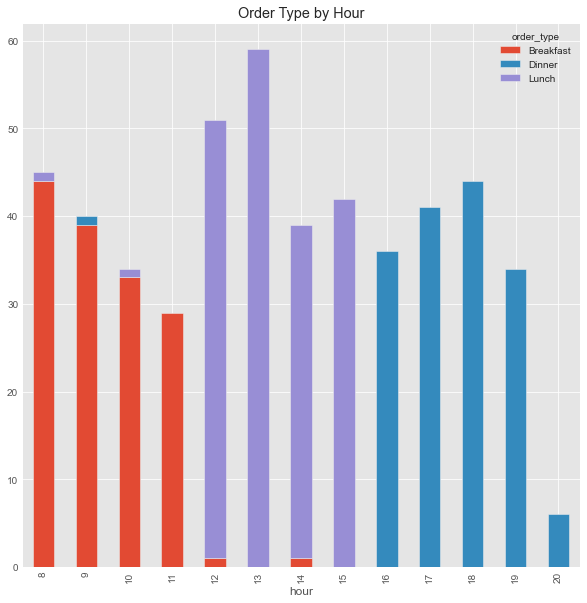

In [345]:
#setup
plt.figure(figsize=(10,10))
#reshape the data
time_plot = (dirty_data[['order_type','hour','order_id']]
 .groupby(['order_type','hour'])
 .size()
 .reset_index()
 .pivot(columns="order_type",index="hour",values=0))
#plot the data
time_plot.plot(kind="bar",stacked=True,figsize=(10,10))
plt.title("Order Type by Hour")
plt.style.use('seaborn-darkgrid')
plt.show()

From the above, we can see the following:
1. Some breakfast observations are flagged as dinner and lunch.
2. some Lunch observations are flagged as breakfast.

In [346]:
# review breakfast observations
#create temporary mask
_ =(dirty_data.hour < 12) & (dirty_data.order_type != "Breakfast")
#display results
dirty_data.loc[_,:]


,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,hour,minute,second
303,ORDA09446,2021-01-31,1900-01-01 09:00:50,Dinner,BK,"[('Coffee', 10), ('Cereal', 1), ('Pancake', 9)...",380.25,-37.798457,144.979611,0,6.970,14.257849,9,0,50
360,ORDK05672,2021-03-5,1900-01-01 10:01:41,Lunch,BK,"[('Eggs', 7), ('Cereal', 1), ('Coffee', 3)]",183.50,-37.822528,144.950320,0,9.042,14.153578,10,1,41
475,ORDX05337,2021-01-20,1900-01-01 08:30:25,Lunch,BK,"[('Cereal', 3), ('Coffee', 2), ('Pancake', 4),...",202.00,-37.817875,144.956320,0,8.525,13.722331,8,30,25


In [347]:
#fix breakfast observations
bf_mask = (dirty_data.hour < 12) & (dirty_data.order_type != "Breakfast")
dirty_data.loc[bf_mask,'order_type'] = "Breakfast"

The fix for these entries will be to swap the order type for Lunch.

In [348]:
# review breakfast observations
#create temporary mask
_ = ((dirty_data.hour >=12)  & (dirty_data.hour <= 14)) & (dirty_data.order_type != "Lunch")
#display results
dirty_data.loc[_,:]

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee,hour,minute,second
227,ORDJ04089,2021-05-21,1900-01-01 12:33:48,Breakfast,TP,"[('Steak', 10), ('Chicken', 6)]",642.0,-37.813249,144.937156,0,10.529,13.214083,12,33,48
236,ORDJ06516,2021-07-17,1900-01-01 14:25:21,Breakfast,TP,"[('Salad', 2), ('Steak', 3), ('Fries', 2)]",193.4,-37.813381,144.973869,0,8.609,13.785865,14,25,21


In [349]:
#fix lunch observations
#create mask
lun_mask = ((dirty_data.hour >=12)  & (dirty_data.hour <= 14)) & (dirty_data.order_type != "Lunch")
#reassign value
dirty_data.loc[lun_mask,'order_type'] = "Lunch"

Finally, we can replot the dataset to review the changes were implemented properly:

<Figure size 720x720 with 0 Axes>

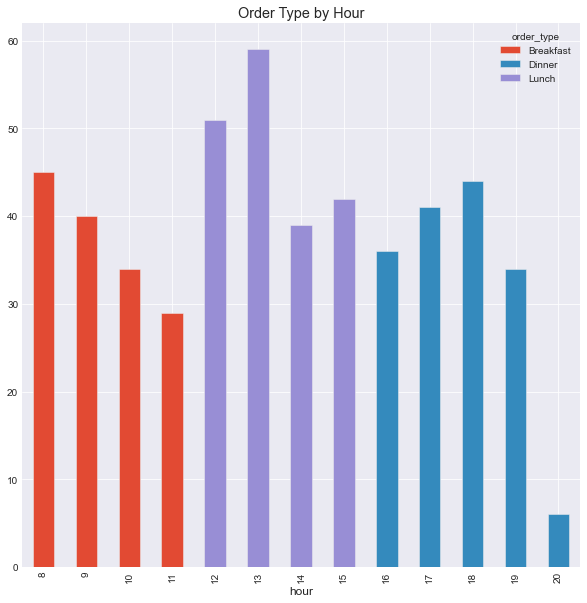

In [350]:
#setup
plt.figure(figsize=(10,10))
#reshape the data
time_plot = (dirty_data[['order_type','hour','order_id']]
			 .groupby(['order_type','hour'])
			 .size()
			 .reset_index()
			 .pivot(columns="order_type",index="hour",values=0))
#plot the data
time_plot.plot(kind="bar",stacked=True,figsize=(10,10))
plt.title("Order Type by Hour")
plt.style.use('seaborn-darkgrid')
plt.show()

#### Branch Code

<AxesSubplot:xlabel='branch_code'>

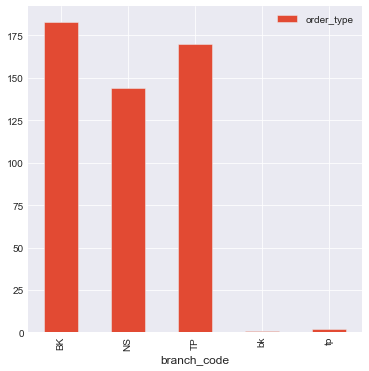

In [351]:
# fix casing 
dirty_data[['branch_code','order_type']].groupby('branch_code').count().plot(kind="bar",figsize=
(6,6))

There seems to be an issue with the casing of branch codes. The fix is straightforward:

In [352]:
dirty_data['branch_code'] = dirty_data['branch_code'].str.upper()

In [353]:
# re-check
dirty_data['branch_code'].value_counts()

BK    184
TP    172
NS    144
Name: branch_code, dtype: int64

#### Order items
Order items is made of tuples containing order items and order quantity, and from the brief we
know that the quantity is correct. Therefore the focus will be review the order_items and find
any potential issues.
<br>
Firstly, we need to identify which items correspond to which order meal. Secondly, since we know
that the `missing_data` dataframe contains correct values, we will use it instead of the
`dirty_data` items.

In [354]:
from ast import literal_eval
#slicing the dataframe
orders_df = missing_data.loc[:,['order_items','order_price','order_type','order_id']]
#convert column string representation into list with literal eval
orders_df.loc[:,'order_items'] = orders_df['order_items'].apply(literal_eval)
# unpack tuple into order type item and quantity with explode
orders_df_unpacked = orders_df.explode('order_items')
#unpacking tuples with zip by quantity and item
orders_df_unpacked['oi_meal'], orders_df_unpacked['oi_quantity']  = zip(*orders_df_unpacked.order_items)

Next, we can create a list of unique items for each order type with some simple pandas methods:

In [355]:
# breakfast meals
bf_meals = (orders_df_unpacked
 .loc[orders_df_unpacked.order_type == "Breakfast","oi_meal"]
 .unique()
 .tolist())
print("---- Breakfast meals ----")
display(bf_meals)
# lunch meals
print("---- Lunch meals ----")
lunch_meals = (orders_df_unpacked
			.loc[orders_df_unpacked.order_type == "Lunch","oi_meal"]
			.unique()
            .tolist())
display(lunch_meals)
print("---- Dinner meals ----")
#dinner meals
dinner_meals = (orders_df_unpacked
			   .loc[orders_df_unpacked.order_type == "Dinner","oi_meal"]
			   .unique()
               .tolist())
display(dinner_meals)

# create a dictionary of meals
meals_dict = dict.fromkeys(bf_meals, 'Breakfast')
meals_dict.update(dict.fromkeys(lunch_meals, 'Lunch'))
meals_dict.update(dict.fromkeys(dinner_meals, 'Dinner'))
# create a list of all meals
meals = sorted(bf_meals + lunch_meals + dinner_meals)

---- Breakfast meals ----


['Cereal', 'Eggs', 'Coffee', 'Pancake']

---- Lunch meals ----


['Burger', 'Fries', 'Chicken', 'Steak', 'Salad']

---- Dinner meals ----


['Salmon', 'Pasta', 'Fish&Chips', 'Shrimp']

From the above, we can conclude that the following items are regularly included in each type of
meal:
* **Breakfast**: it should only include Cereal, Coffee, Eggs and Pancakes.
* **Lunch**: it should only include Burger, Chicken, Fries, Salad and Steak.
* **Dinner**: it should only include Fish&Chips, Pasta, Salmon and Shrimp.

Next, we need to fix the entries for each one of the entries in the `dirty_data` dataframe with
incorrect order_types:

In [356]:
#slicing the dataframe
d_orders_df = dirty_data.loc[:,['order_items','order_price','order_type','order_id']]
#convert column string representation into list with literal eval
d_orders_df.loc[:,'order_items'] = d_orders_df['order_items'].apply(literal_eval)
# unpack tuple into order type item and quantity with explode
d_orders_df_unpacked = d_orders_df.explode('order_items')
#unpacking tuples with zip by quantity and item
d_orders_df_unpacked['oi_meal'], d_orders_df_unpacked['oi_quantity']  = zip(*d_orders_df_unpacked.order_items)

In [357]:
# filter out orders that should be breakfast by content, but are not flagged as breakfast
_bf = (d_orders_df_unpacked.oi_meal.isin(bf_meals))& (d_orders_df_unpacked.order_type !=
                                                      "Breakfast")
print("---- Wrongly assigned breakfast orders ----")
display(d_orders_df_unpacked.loc[_bf,:])

# filter out orders that should be lunch by content, but are not flagged as lunch
_ln = (d_orders_df_unpacked.oi_meal.isin(lunch_meals))& (d_orders_df_unpacked.order_type !=
													  "Lunch")
print("---- Wrongly assigned lunch orders ----")
display(d_orders_df_unpacked.loc[_ln,:])
# filter out orders that should be dinner by content, but are not flagged as dinner
_dn = (d_orders_df_unpacked.oi_meal.isin(dinner_meals))& (d_orders_df_unpacked.order_type !=
														 "Dinner")
print("---- Wrongly assigned dinner orders ----")
display(d_orders_df_unpacked.loc[_dn,:])

---- Wrongly assigned breakfast orders ----


,order_items,order_price,order_type,order_id,oi_meal,oi_quantity
25,"(Pancake, 9)",679.0,Dinner,ORDB06978,Pancake,9
177,"(Eggs, 10)",440.4,Lunch,ORDZ08163,Eggs,10
208,"(Cereal, 4)",272.0,Lunch,ORDI08090,Cereal,4
232,"(Coffee, 10)",824.0,Lunch,ORDA10473,Coffee,10


---- Wrongly assigned lunch orders ----


,order_items,order_price,order_type,order_id,oi_meal,oi_quantity
371,"(Chicken, 7)",503.0,Dinner,ORDJ07072,Chicken,7


---- Wrongly assigned dinner orders ----


,order_items,order_price,order_type,order_id,oi_meal,oi_quantity
201,"(Salmon, 10)",871.4,Lunch,ORDA10125,Salmon,10
252,"(Fish&Chips, 2)",289.5,Breakfast,ORDX03613,Fish&Chips,2


Next, we need to check what menu item should actually go on the order based on the total order
price.
<br>
To do so, we need to create a matrix to compare meal items and quantities, and use a system of
equations to derive the individual price of each item.

In [358]:
# add real order type to dirty dataframe
d_orders_df_unpacked['r_order_type'] = d_orders_df_unpacked.apply(lambda x:meals_dict[x['oi_meal']],
                                                                  axis =1 )

We need to create a square (nxn) matrix to be able to apply linear algebra operations:

In [359]:
# create a matrix to be used in the system of equations, replacing NaN values with zeroes.
# we will also convert the dataframe to an array
items_array = (orders_df_unpacked
 .pivot(columns="oi_meal")["oi_quantity"]
 .fillna(0)
 .values)

# get prices
order_price = np.array(missing_data['order_price'])
#  linear algebra operations
prices = np.linalg.lstsq(items_array,order_price,rcond=None)[0]
# create price dictionary
prices_dict = dict(zip(meals, (list(np.around(np.array(prices),2)))))

In [360]:
print("---- Prices Dictionary ----")
prices_dict

---- Prices Dictionary ----


{'Burger': 31.0,
 'Cereal': 20.0,
 'Chicken': 32.0,
 'Coffee': 5.5,
 'Eggs': 21.0,
 'Fish&Chips': 35.0,
 'Fries': 12.0,
 'Pancake': 22.25,
 'Pasta': 27.5,
 'Salad': 17.2,
 'Salmon': 41.0,
 'Shrimp': 54.0,
 'Steak': 45.0}

Next, we will need to add the prices derived above to the

In [361]:
# next, we can review the items
d_orders_df_unpacked['price'] = d_orders_df_unpacked.apply(lambda x:prices_dict[x['oi_meal']],
                                                           axis=1)
# and add the real total price of each item sold
d_orders_df_unpacked['total_price'] = d_orders_df_unpacked.oi_quantity * d_orders_df_unpacked.price

d_orders_df_unpacked.head()

,order_items,order_price,order_type,order_id,oi_meal,oi_quantity,r_order_type,price,total_price
0,"(Salmon, 4)",308.0,Dinner,ORDJ06243,Salmon,4,Dinner,41.0,164.0
0,"(Pasta, 2)",308.0,Dinner,ORDJ06243,Pasta,2,Dinner,27.5,55.0
0,"(Fish&Chips, 1)",308.0,Dinner,ORDJ06243,Fish&Chips,1,Dinner,35.0,35.0
0,"(Shrimp, 1)",308.0,Dinner,ORDJ06243,Shrimp,1,Dinner,54.0,54.0
1,"(Salmon, 5)",342.5,Dinner,ORDA10907,Salmon,5,Dinner,41.0,205.0


To fix the wrong order items, the easiest methods will be to iterate through the orders with
wrong items and:
1. Change the order type to the proper value.
2. Calculate the correct total price for the order.
3. Finish the rest.

In [362]:
# create mask for non-matching order types
_ = d_orders_df_unpacked.order_type != d_orders_df_unpacked.r_order_type
#create list of ID's to be inspected
incorrect_ids = d_orders_df_unpacked.loc[_,"order_id"].to_list()
# for each in incorrect_ids:
#     order = d_orders_df_unpacked[d_orders_df_unpacked == each]
#     print(order)
print("---- Head of Dirty Data incorrect order types ----")
display(d_orders_df_unpacked.loc[d_orders_df_unpacked.order_id.isin(incorrect_ids),:].head())

---- Head of Dirty Data incorrect order types ----


,order_items,order_price,order_type,order_id,oi_meal,oi_quantity,r_order_type,price,total_price
25,"(Pasta, 10)",679.0,Dinner,ORDB06978,Pasta,10,Dinner,27.50,275.00
25,"(Fish&Chips, 1)",679.0,Dinner,ORDB06978,Fish&Chips,1,Dinner,35.00,35.00
25,"(Pancake, 9)",679.0,Dinner,ORDB06978,Pancake,9,Breakfast,22.25,200.25
177,"(Eggs, 10)",440.4,Lunch,ORDZ08163,Eggs,10,Breakfast,21.00,210.00
177,"(Salad, 7)",440.4,Lunch,ORDZ08163,Salad,7,Lunch,17.20,120.40


The purpose of the next loop is to derive the proper items that should be in the order by
estimating the total price difference between the items that are indeed correct with the given
total order quantity. This would leave us with a single price that we can then compare against
the list of unit prices to match the item that should be in the order:

In [363]:
for each in incorrect_ids:
    #fetch order
    order = d_orders_df_unpacked[d_orders_df_unpacked.order_id == each]
    # get correct items within the order
    order_correct = order[order.order_type == order.r_order_type]
    # get price for correct items_array
    correct_items_sum = order_correct['total_price'].sum()
    #calculate difference from real total versus given total
    dif = round(order['order_price'].iloc[0] - correct_items_sum,2)
    #get correct items into a list and list which items are missing
    correct_items = order_correct['oi_meal'].values.tolist()
    #get price of missing items
    missing = list(filter(lambda x: x not in correct_items, meals))
    #get quantities for incorrect order items
    order_incorrect_qty = order[order.order_type != order.r_order_type]['oi_quantity'].values\
        .tolist()[0]
    #find missing meals
    #by first collecting all the prices of missing meals
    missing_prices = [(each,prices_dict[each]) for each in missing]
    # find missing meal
    missing_meal = None
    for price in missing_prices:
        if price[1] * order_incorrect_qty == dif:
            missing_meal = price[0]
    #create temporary mask
    _ = (d_orders_df_unpacked.order_id == each) & (d_orders_df_unpacked.order_type !=
                                                   d_orders_df_unpacked.r_order_type)

    #use mask and replace meals
    d_orders_df_unpacked.loc[_,"oi_meal"] = missing_meal
    # #convert item and quantity into tuple
    d_orders_df_unpacked['order_items'] = list(zip(d_orders_df_unpacked.oi_meal,
												   d_orders_df_unpacked.oi_quantity))

Next, we will collapse the exploded data frame that we have amended with the following pandas
operations:

In [364]:
#reconvert tuple to string
d_orders_df_unpacked['order_items'] = d_orders_df_unpacked.order_items.astype(str)
#group them by order id
d_orders_df_unpacked = (d_orders_df_unpacked.groupby('order_id',as_index=False)
                        .agg({'order_items': lambda x: x.tolist()}))
#create a copy of dirty_data
dirty_data_c = dirty_data.copy()
#and merge items on order_id
dirty_data_c = pd.merge(dirty_data_c,d_orders_df_unpacked,how="left",on=["order_id"])

In [378]:
#mantain order items from the fixed dataframe
#also, change the format to string and fix formatting of order_items
dirty_data.loc[:,'order_items'] = (dirty_data_c.loc[:,'order_items_y']
                                   .astype(str))
dirty_data.loc[:,'order_items'] = dirty_data.order_items.str.replace(r'"', '')

#### Customer location

In [138]:
# lets map!

In [139]:
import plotly.express as px

-------------------------------------

In [140]:
df = dirty_data[['customer_lon','customer_lat','order_price']]
fig = px.scatter_geo(df, lon='customer_lon',lat='customer_lat')
fig.show()
# ! need to zoom in, but there's clearly an error considering all customers are melb based.

There are clearly some issues with the location of some of the customers, as they should all fall under the Melbourne city region. We will review the `customer_lon` and `customer_lat` variables separately:

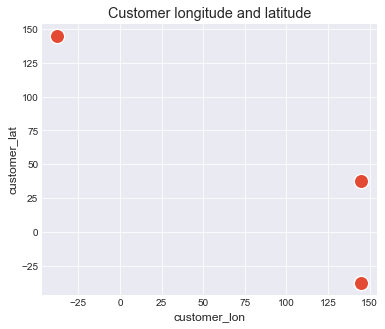

In [141]:
#review customer latitude
dimens = (6, 5)
fig, ax = plt.subplots(figsize=dimens)
sns.scatterplot(data = dirty_data, x = 'customer_lon', y = 'customer_lat',s=200,
                x_jitter=100, y_jitter=100, ax=ax)
plt.title("Customer longitude and latitude")
plt.show()

From the above plot, we can see that some `customer_lat` observations have issues as they're too
far apart from the rest of the observations:

In [142]:
dirty_data[['customer_lon','customer_lat']].loc[dirty_data.customer_lat > 25,:]

,customer_lon,customer_lat
15,144.952277,37.805486
152,-37.806815,144.937983
176,-37.808185,144.921075
212,145.015337,37.821844
330,144.959017,37.824914
376,144.962551,37.818812
412,-37.816142,144.964177
426,-37.799907,145.000032
474,-37.798359,144.952302


The melbourne longitude is close to -37.8, while the latitude is close to 145. Also, since the latitude values ranges from -90 to 90, it should be obvious that the columns need to be swapped:

In [143]:
dirty_data.customer_lat,dirty_data.customer_lon =np.where(dirty_data['customer_lat']>90,
                                                           (dirty_data['customer_lon'],dirty_data['customer_lat']),
                                                           (dirty_data['customer_lat'],dirty_data['customer_lon']))

We also need to revert transform the `customer_lat` values that are positive values into negatives:

In [144]:
#create mask
_ = dirty_data.customer_lat > 0
# filter out results and re-assign by multiplying itself to -1.
dirty_data.loc[_,"customer_lat"] *= -1

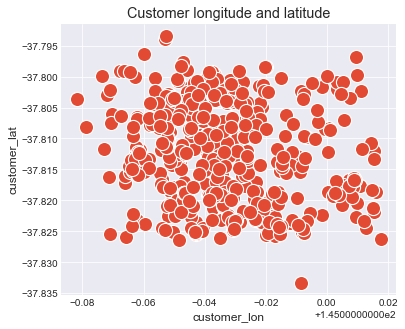

In [145]:
# review the coordinates again
#review customer latitude
dimens = (6, 5)
fig, ax = plt.subplots(figsize=dimens)
sns.scatterplot(data = dirty_data, x = 'customer_lon', y = 'customer_lat',s=200,
                x_jitter=100, y_jitter=100, ax=ax)
plt.title("Customer longitude and latitude")
plt.show()

#### Distance to Customer

As per the assignment brief, we will use Djikstra's algorithm to find the shortest path between
two nodes in the graph.
<br>
First, we will load the data into dataframes and run simple summaries:

In [146]:
# use supplementary files
nodes = pd.read_csv('supplementary_files/nodes.csv')
edges = pd.read_csv('supplementary_files/edges.csv')
branches = pd.read_csv('supplementary_files/branches.csv')

In [147]:
#review
print("---- nodes head ----")
display(nodes.head())
print("---- edges head ----")
display(edges.head())
print("---- branches head ----")
display(branches.head())

---- nodes head ----


,node,lat,lon
0,711327755,-37.807675,144.955873
1,711327756,-37.807094,144.955978
2,711327759,-37.807301,144.957817
3,711327760,-37.807885,144.957719
4,777781264,-37.805221,144.952173


---- edges head ----


,Unnamed: 0,u,v,distance(m),street type,speed(km/h)
0,0,711327755,711332946,58.0,1,15.0
1,2,711327755,55725841,15.0,2,20.0
2,3,711327755,711327760,165.0,1,15.0
3,4,711327756,703557073,4.0,0,10.0
4,5,711327756,711332946,8.0,1,15.0


---- branches head ----


,branch_code,branch_name,branch_lat,branch_lon
0,NS,Nickolson,-37.773803,144.983647
1,TP,Thompson,-37.861835,144.905716
2,BK,Bakers,-37.815834,145.046450


In [148]:
# merge nodes to branches to add labels
branches_labeled = pd.merge(branches,nodes, how='left', left_on=['branch_lat','branch_lon'],
                            right_on=['lat','lon'])
print("---- labeled branches head ----")
display(branches_labeled)

---- labeled branches head ----


,branch_code,branch_name,branch_lat,branch_lon,node,lat,lon
0,NS,Nickolson,-37.773803,144.983647,2455254505,-37.773803,144.983647
1,TP,Thompson,-37.861835,144.905716,1390575046,-37.861835,144.905716
2,BK,Bakers,-37.815834,145.046450,1889485053,-37.815834,145.046450


In [149]:
# add corresponding branch node to each customer purchase

test = pd.merge(dirty_data[['branch_code','customer_lat','customer_lon']],
                branches_labeled[['branch_code','node']],
                how='left')

#rename column
test.rename(columns={'node':'b_node'},inplace=True)
# add customer's node from the nodes file
test.head()

,branch_code,customer_lat,customer_lon,b_node
0,TP,-37.806521,144.944874,1390575046
1,BK,-37.810712,144.946133,1889485053
2,BK,-37.819004,144.954318,1889485053
3,TP,-37.817244,144.967764,1390575046
4,BK,-37.809557,144.972643,1889485053


Now we need to add the customer's nodes to the dataset.


In [150]:
# Review
test = pd.merge(test,nodes,how='left',left_on=['customer_lat','customer_lon'],right_on=['lat',
                                                                                        'lon'])
# rename column
test.rename(columns={"node":"c_node"},inplace=True)
test.head()

,branch_code,customer_lat,customer_lon,b_node,c_node,lat,lon
0,TP,-37.806521,144.944874,1390575046,4633770157,-37.806521,144.944874
1,BK,-37.810712,144.946133,1889485053,4655086236,-37.810712,144.946133
2,BK,-37.819004,144.954318,1889485053,2174963240,-37.819004,144.954318
3,TP,-37.817244,144.967764,1390575046,4329375111,-37.817244,144.967764
4,BK,-37.809557,144.972643,1889485053,589424371,-37.809557,144.972643


For the Dijkstra's Path algorithm we will only use the node columns, and therefore we will create
 a copy and slice the `customers_df` on two columns first:

In [151]:
# slice dataframe
dijk_df = test[['b_node','c_node']]
# create graph
g= nx.Graph()

#add nodes to the graph
for i in range(len(nodes)):
    g.add_node(nodes['node'][i],pos = (nodes['lat'][i],nodes['lon'][i]))

#add edges to the graph
for i in range(len(edges)):
	g.add_edge(edges['u'][i],edges['v'][i], weight=edges['distance(m)'].iat[i]/1000)

In [153]:
dijk_df.head()

,b_node,c_node
0,1390575046,4633770157
1,1889485053,4655086236
2,1889485053,2174963240
3,1390575046,4329375111
4,1889485053,589424371


In [160]:
#use networkx dijkstra_path_length to calculate distances between nodes
distances = [nx.dijkstra_path_length(g,source=dijk_df['b_node'][i],target=dijk_df['c_node'][i])
             for i in range(len(dijk_df))]

In [164]:
#round numbers to three decimals
distances = list(np.around(np.array(distances), 3))
#append distance to sliced dataframe
dijk_df.loc[:,"distances"] = distances
# replace the distances column into the new dataframe
dirty_data.loc[:,'distance_to_customer_KM'] = dijk_df.loc[:,"distances"]

/var/folders/xl/qhtvn7sx5hv_3l1z6p_qqld40000gn/T/ipykernel_48597/2213265600.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Customer Loyalty

The variable `customerHasLoyalty` is a binary variable (1 equal to Loyalty member), and as the
brief mentions it can be cross-checked against the fees that the customers are paying for the
deliveries.
<br>
First, we will quickly inspect the variable with a simple plot:

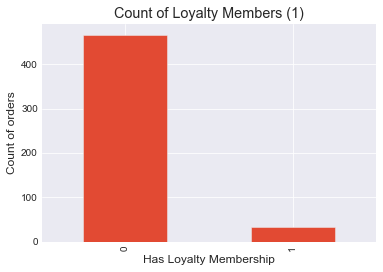

In [176]:
#### some code
dirty_data['customerHasloyalty?'].value_counts().plot(kind="bar")
plt.xlabel("Has Loyalty Membership")
plt.ylabel("Count of orders")
plt.title("Count of Loyalty Members (1)")
plt.show()

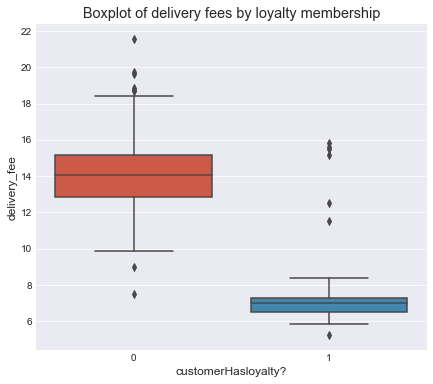

In [194]:
fig, ax = plt.subplots(figsize=(7,6))
sns.boxplot(data=dirty_data, x="customerHasloyalty?", y="delivery_fee", ax=ax)
plt.title("Boxplot of delivery fees by loyalty membership")
plt.show()

From the above plot we can see that some observations for customers that aren't part of the loyalty
program are being charged within the range of a customer with loyalty membership preferences.
<br>
To select these observations, we will need to (1) compute the IQR value for customers that don't
belong to the loyalty program, (2) filter their orders and (3) swap the entries on loyalty
indicator column to 1.

In [228]:
from scipy.stats import iqr

# create mask for customers with and without loyalty
nl_ = (dirty_data["customerHasloyalty?"] == 0)
l_ = (dirty_data["customerHasloyalty?"] == 1)
#select
no_loyalty = dirty_data.loc[nl_,"delivery_fee"]
loyalty = dirty_data.loc[l_,"delivery_fee"]
#calculate IQR
iqr = iqr(no_loyalty,interpolation="midpoint")
#calculate Q1 and Q3 for delivery fees of no-loyalty
q1 = np.percentile(no_loyalty,25,interpolation="midpoint")
q3 = np.percentile(no_loyalty,75,interpolation="midpoint")

Next, we will filter out the order id's of these observations and swap the indicator.

In [240]:
#mask
_ = no_loyalty < (q1 - 1.5 * iqr)

### Missing Data

This section will review the `missing_data` data frame and will analise the integrity of the data based on its missigness.
<br>
A dataset missingess describes the type of missing information:
* Missing at random
* Missing completely at random
* Missing not at random

For this section we will use `pandas` as well as the `missigno` library to review the dataframe's
 missigness characteristics.

In [481]:
# note that missing data may be represented as something other than Nan and should be converted
# appropriately.

By using the info method from the `pandas` library we can concisely see the non-null counts for
each one of the variables in the dataset. As a result, we can see that `branch_code` as well as
`delivery_fee` have null values that require further inspection.

In [482]:
# test
missing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   order_id                 500 non-null    object 
 1   date                     500 non-null    object 
 2   time                     500 non-null    object 
 3   order_type               500 non-null    object 
 4   branch_code              450 non-null    object 
 5   order_items              500 non-null    object 
 6   order_price              500 non-null    float64
 7   customer_lat             500 non-null    float64
 8   customer_lon             500 non-null    float64
 9   customerHasloyalty?      500 non-null    int64  
 10  distance_to_customer_KM  500 non-null    float64
 11  delivery_fee             400 non-null    float64
dtypes: float64(5), int64(1), object(6)
memory usage: 47.0+ KB


Brief introduction of the dataset.

<AxesSubplot:>

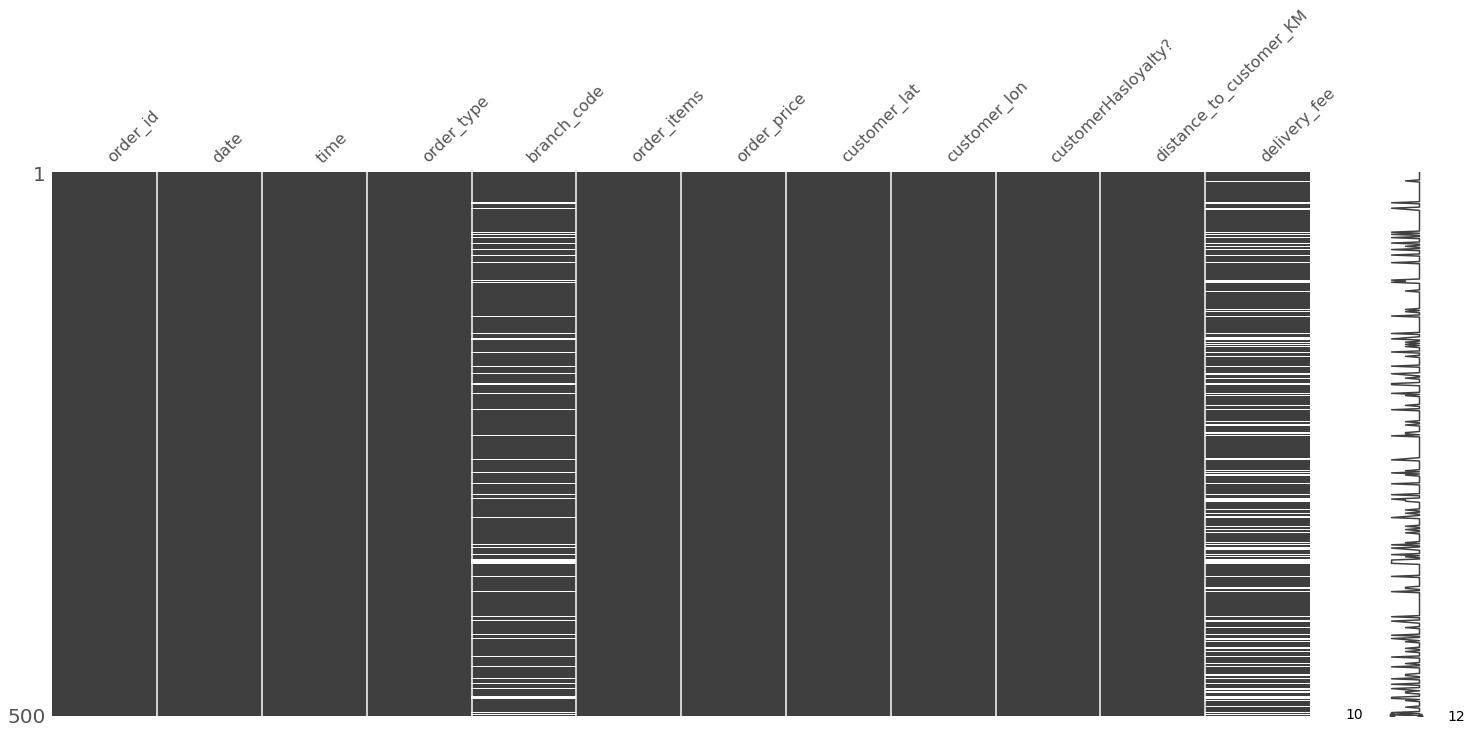

In [483]:
msno.matrix(df =missing_data)

The above charts display potential issues in the `branch_code` and `delivery_fee` fields

#### Branch Code

In order to find the best possible value to fill in the missing branch codes, we will print the head values of the data frame to find associated variables:

In [484]:
missing_data.head()

,order_id,date,time,order_type,branch_code,order_items,order_price,customer_lat,customer_lon,customerHasloyalty?,distance_to_customer_KM,delivery_fee
0,ORDB03023,2021-09-09,16:16:54,Dinner,TP,"[('Salmon', 6), ('Pasta', 1), ('Fish&Chips', 1)]",308.5,-37.811774,145.002000,0,11.108,15.675114
1,ORDX01158,2021-08-11,15:16:03,Lunch,BK,"[('Burger', 5), ('Fries', 7)]",239.0,-37.800240,144.984491,0,6.440,12.266605
2,ORDJ01203,2021-01-17,08:30:25,Breakfast,TP,"[('Cereal', 5), ('Eggs', 9)]",289.0,-37.817335,144.962208,1,7.904,5.796403
3,ORDY00837,2021-09-13,16:27:02,Dinner,TP,"[('Pasta', 2), ('Salmon', 7)]",342.0,-37.804640,144.971640,0,9.800,13.371503
4,ORDK09018,2021-11-16,18:28:43,Dinner,BK,"[('Salmon', 6), ('Pasta', 4)]",356.0,-37.825059,144.928569,0,15.180,22.281960


It's possible that we could derive the missing branch codes with the `order_id` field, as there seems to be a pattern with the digits:

In [498]:
# create a copy df
missing_data_i = missing_data.copy()
# create new column for the order_id digits
missing_data_i['id_digs'] = missing_data_i['order_id'].str[:4]

In [499]:
missing_data_impute[['branch_code','id_digs','order_id']].groupby(['branch_code','id_digs']).count()

order_id
branch_code id_digs          
BK          ORDA           40
            ORDK           68
            ORDX           47
NS          ORDC           53
            ORDI           47
            ORDZ           57
TP          ORDB           49
            ORDJ           44
            ORDY           45

As suspected, each branch code has three different types of order id digits that are unique to that branch. Therefore we will use this logic to fill the null values of `branch_code`. Also, its important to mention that this type of missigness falls under the **"MNAR"** type. To fill in the values, we will filter the dataframe by the new created `id_digs` column, combined with null values on branch code. Lastly, we will simply use the mask created and assign the proper branch code to the selection.

In [503]:
# create a mask of null values for each branch
bk_mask  = ((missing_data_i['id_digs'] == 'ORDA') | (missing_data_i['id_digs'] == 'ORDK') | (missing_data_i['id_digs'] == 'ORDX')) & missing_data_i['branch_code'].isnull()
ns_mask  = ((missing_data_i['id_digs'] == 'ORDC') | (missing_data_i['id_digs'] == 'ORDI') | (missing_data_i['id_digs'] == 'ORDZ')) & missing_data_i['branch_code'].isnull()
tp_mask  = ((missing_data_i['id_digs'] == 'ORDB') | (missing_data_i['id_digs'] == 'ORDJ') | (missing_data_i['id_digs'] == 'ORDY')) & missing_data_i['branch_code'].isnull()
# re assign values by using the mask
missing_data_i.loc[bk_mask,'branch_code'] = "BK"
missing_data_i.loc[ns_mask,'branch_code'] = "NS"
missing_data_i.loc[tp_mask,'branch_code'] = "TP"

#### Delivery Fee

In [501]:
# from statsmodels.formula.api import ols
# from scipy import stats
# import statsmodels.api as sm
# from statsmodels.sandbox.regression.predstd import wls_prediction_std

# method 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression

In [502]:
lm = LinearRegression

Based on the assignment brief, we will need to create dummy variables to be used in a linear regression based on the following aspects of the data:
1. is_weekend = 1 if the day of the order is Saturday or Sunday, or 0 otherwise.
2. is_morning = 0 if morning, 1 for afternoon and 2 for evening.

Also, it's important to note that customers that are part of the loyalty program get a 50% discount, distance needs to be considered and each branch has it's own delivery fee calculation.

Firstly, we will create masks to segment the data based on Branch:

In [490]:
# # create a branch code and null delivery fee mask and non-null variables
# fee_bk_mask = (missing_data_c['branch_code'] == 'BK') & (missing_data_c['delivery_fee'].notna())
# fee_ns_mask = (missing_data_c['branch_code'] == 'NS') & (missing_data_c['delivery_fee'].notna())
# fee_tp_mask = (missing_data_c['branch_code'] == 'TP') & (missing_data_c['delivery_fee'].notna())

# create a branch code and null delivery fee mask and non-null variables
fee_bk_mask = (missing_data_c['branch_code'] == 'BK')
fee_ns_mask = (missing_data_c['branch_code'] == 'NS')
fee_tp_mask = (missing_data_c['branch_code'] == 'TP')

Next, we need to create dummy variables that will allow us to run a regression on categorical variables.

##### Delivery Fee dummy variables

We will create a dummy variable for the day of the week contained in `date` by using a simple pandas filtering, and assigning the value of one or zero.

In [492]:
# change date datatype to datetime
missing_data_c['date'] = pd.to_datetime(missing_data_c["date"])
#create new empty variable
missing_data_c['is_weekend'] = np.nan
# assign value based on the weekday
missing_data_c.loc[missing_data_c.date.dt.weekday >= 5, 'is_weekend'] = 1
missing_data_c.loc[missing_data_c.date.dt.weekday < 5, 'is_weekend'] = 0

In [493]:
#is_morning
order_dummies = pd.get_dummies(missing_data_c.order_type, drop_first=True, prefix='order_type')

In [494]:
#overwritting the dataset with the appended extra column.
missing_data_c = pd.concat([missing_data_c,order_dummies], axis=1)

With the last transformation above we've now created all the necessary variables are ready to be used in a linear regression model.

We only need some of the variables to be included in the model. Therefore, first we will slice the original copy into a version with fewer columns:

In [495]:
#test without the converted delivery fee:

# slicing the model
missing_data_c_ls = missing_data_c.iloc[:,9:]
# dropping unn
missing_data_c_ls.drop(columns=['id_digs'], axis=1, inplace=True)
# looking at the first observations
missing_data_c_ls.head()

,customerHasloyalty?,distance_to_customer_KM,delivery_fee,is_weekend,order_type_Dinner,order_type_Lunch,order_type_Dinner,order_type_Lunch
0,0,11.108,15.675114,0.0,1,0,1,0
1,0,6.440,12.266605,0.0,0,1,0,1
2,1,7.904,5.796403,1.0,0,0,0,0
3,0,9.800,13.371503,0.0,1,0,1,0
4,0,15.180,22.281960,0.0,1,0,1,0


For X, we will keep all the variables except `delivery_fee`, as that is the dependent variable.

##### Delivery Fee linear regression: BK branch

In [410]:
# assigning variables with the non-null dataset
X = missing_data_c_ls.loc[fee_bk_mask,:].drop('delivery_fee', axis=1)
y = missing_data_c_ls.loc[fee_bk_mask,:].delivery_fee

In [411]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
#creating and training the model
from sklearn.linear_model import LinearRegression
#instantiate model
lm = LinearRegression()
# train model
lm.fit(X_train,y_train)

LinearRegression()

In [412]:
#printing the coefficients
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
customerHasloyalty?,-7.137912
distance_to_customer_KM,1.040017
is_weekend,2.477344
order_type_Dinner,1.890530
order_type_Lunch,1.093601


In [413]:
print ('r-squared for this model = ',lm.score(X_test,y_test))

r-squared for this model =  0.9863619182167275


In [414]:
# assigning variables with the non-null dataset
lm.predict(missing_data_c_ls.loc[fee_bk_mask,:].drop('delivery_fee', axis=1))

array([12.36786682, 22.25454598, 15.45513504, 15.21751401, 14.49497746,
       13.15984026, 17.22373047, 11.40325116, 15.85636001, 13.11254238,
       12.94765351, 13.48824079, 16.44161429, 17.81030019, 16.65169777,
       14.39382037, 14.20689269, 10.31848996, 18.91193061, 13.64112332,
       14.76852522, 14.00616936, 13.46612501, 14.18609234, 15.7822666 ,
       15.82723952, 12.50202904, 12.620591  , 13.59820719, 18.77984843,
       10.09362456, 16.56435955, 13.59820719, 16.95070304,  7.2272852 ,
       19.96341126, 14.70090087, 13.92633295, 12.69443223, 13.37094052,
       15.09216903, 12.67571192, 14.64446452, 16.20867366, 15.64236137,
       15.39897411, 14.91722445, 15.312431  , 15.04432823, 14.16113193,
        9.81824168, 12.62995116, 12.22692157, 13.1998806 ,  8.03225853,
       13.279419  , 13.97311049, 11.36529021, 14.92970466, 13.28357907,
       16.20865043, 17.27910357, 14.7214258 , 17.9852985 , 11.74933199,
       12.51866931, 15.64288106, 13.48900539, 15.23130965, 15.72

In [ ]:
# assign values to null values
missing_data_c_ls.loc[]

##### Delivery Fee linear regression: NS branch

In [223]:
# assigning variables
X = missing_data_c_ls.loc[fee_ns_mask,:].drop('delivery_fee', axis=1)
y = missing_data_c_ls.loc[fee_ns_mask,:].delivery_fee

In [367]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
#creating and training the model
from sklearn.linear_model import LinearRegression
#instantiate model
lm = LinearRegression()
# train model
lm.fit(X_train,y_train)

LinearRegression()

In [368]:
#printing the coefficients
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
customerHasloyalty?,-7.137912
distance_to_customer_KM,1.040017
is_weekend,2.477344
order_type_Dinner,1.890530
order_type_Lunch,1.093601


In [369]:
print ('r-squared for this model = ',lm.score(X_test,y_test))

r-squared for this model =  0.9863619182167275


##### Delivery Fee linear regression: TP

In [370]:
# assigning variables
X = missing_data_c_ls.loc[fee_tp_mask,:].drop('delivery_fee', axis=1)
y = missing_data_c_ls.loc[fee_tp_mask,:].delivery_fee

In [374]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
#creating and training the model
from sklearn.linear_model import LinearRegression
#instantiate model
lm = LinearRegression()
# train model
lm.fit(X_train,y_train)

LinearRegression()

In [375]:
#printing the coefficients
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
customerHasloyalty?,-5.892718
distance_to_customer_KM,0.873128
is_weekend,1.331643
order_type_Dinner,1.478950
order_type_Lunch,0.836204


In [376]:
print ('r-squared for this model = ',lm.score(X_test,y_test))

r-squared for this model =  0.9925413909162757


##### Delivery Fee: Using the regression model results

In [234]:
# add some code

### Outlier Data

## Summary <a class="anchor" name="summary"></a>

In conclussion, this excercise has covered all the necessary steps required to process semi-structured files into a unified dataframe that is adequate for analysis.
<br>
The key steps of the process undoubtedly lie on understanding the structure of the information to be structured. In this case, the data was formatted in HTML and hence it wasn't too difficult to design regular expressions that could extract the right type of information.
<br>
With the right regular expression design, the data was extracted using simple loops to store the data into a format that is efficient to parse (in this case, a list). Lastly, the pandas library was extremely helpful in structuring the data in a tabular format that can then be examined.

-------------------------------------

## References <a class="anchor" name="Ref"></a>




[1]<a class="anchor" name="ref-2"></a> Why do I need to add DOTALL to python regular expression to match new line in raw string, https://stackoverflow.com/questions/22610247, Accessed 30/08/2022.


https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
....


https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

dummy variables in pandas
<br>
https://www.youtube.com/watch?v=0s_1IsROgDc

regression summary
<br>
https://www.statology.org/sklearn-linear-regression-summary/

explode list-like columns of a list
<br>
https://towardsdatascience.com/why-and-how-to-explode-a-list-like-column-to-rows-in-pandas-b69c3391c01c

--------------------------------------------------------------------------------------------------------------------------